In [ ]:
!pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 46.4 MB/s eta 0:00:00


In [ ]:
!pip install 'shimmy>=0.2.1'

In [ ]:
# 1. Obtencion de datos
import yfinance as yf

# Descarga los datos de Apple
data = yf.download('AAPL', start='2010-01-01', end='2023-01-01')

# 2. Preparación de datos
# Calcula medias móviles
data['MA14'] = data['Close'].rolling(window=14).mean()
data['MA28'] = data['Close'].rolling(window=28).mean()
data['MA100'] = data['Close'].rolling(window=100).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

# Elimina las filas con NaN (debido a las medias móviles)
data.dropna(inplace=True)

# Divide los datos en entrenamiento y validación
train_data = data.iloc[:int(0.8*len(data))]
val_data = data.iloc[int(0.8*len(data)):]

#3. Entorno de DRL

import gym
from gym import spaces
import numpy as np


class TradingEnv(gym.Env):
    def __init__(self, data, sl=1, tp=3):
        super(TradingEnv, self).__init__()

        # Datos históricos
        self.data = data
        self.current_step = 0
        self.sl = sl
        self.tp = tp

        # Acciones: 0 = mantener, 1 = comprar
        self.action_space = spaces.Discrete(2)

        # Estado: OHLC + Volumen + 4 medias móviles
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(9,), dtype=np.float32)

        # Comprobar si hay una posición abierta
        self.position_open = False

    def reset(self):
        self.current_step = 0
        self.position_open = False
        return self.data.iloc[self.current_step][['Open', 'High', 'Low', 'Close', 'Volume', 'MA14', 'MA28', 'MA100', 'MA200']].values

    def step(self, action):
        self.current_step += 1

        # Si la acción es comprar y no hay una posición abierta
        if action == 1 and not self.position_open:
            self.position_open = True
            self.entry_price = self.data.iloc[self.current_step]['Open']

        reward = 0
        if self.position_open:
            potential_profit = self.data.iloc[self.current_step]['Close'] - self.entry_price
            if potential_profit >= self.tp:
                reward = self.tp
                self.position_open = False  # Cerrar posición
            elif potential_profit <= -self.sl:
                reward = -self.sl
                self.position_open = False  # Cerrar posición

        done = False
        if self.current_step == len(self.data) - 1:
            done = True

        return self.data.iloc[self.current_step][['Open', 'High', 'Low', 'Close', 'Volume', 'MA14', 'MA28', 'MA100', 'MA200']].values, reward, done, {}


    def render(self, mode='human'):
        # Aquí puedes agregar código para visualizar el proceso, si lo deseas
        pass

    def close(self):
        pass

# 4. Entrenamiento del modelo

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Crea el entorno con los datos de entrenamiento
env_train = DummyVecEnv([lambda: TradingEnv(train_data)])

# Crea el modelo
model = PPO("MlpPolicy", env_train, verbose=1)

# Entrena el modelo
model.learn(total_timesteps=200000)

# Evaluar el modelo en datos de validación
env_val = DummyVecEnv([lambda: TradingEnv(val_data)])
obs = env_val.reset()
for _ in range(len(val_data)):
    action, _ = model.predict(obs)
    obs, reward, done, _ = env_val.step(action)

# 5. Guardar el modelo
model.save("path_to_save_model")


[*********************100%%**********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device
-----------------------------
| time/              |      |
|    fps             | 294  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 330        |
|    iterations           | 2          |
|    time_elapsed         | 12         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01628917 |
|    clip_fraction        | 0.0897     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.68      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0003     |
|    loss                 | 0.581      |
|    n_updates            | 10         |
|    policy_gradient_loss | -0.00483   |
|    value_loss           | 1.22       |
----------------------------------------
----------------------------------

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
obs = env_val.reset()
done = False
buy_dates = []
buy_prices = []

while not done:
    action, _ = model.predict(obs)
    obs, _, done, _ = env_val.step(action)
    if action == 1:
        buy_dates.append(val_data.index[env_val.envs[0].current_step])
        buy_prices.append(val_data.iloc[env_val.envs[0].current_step]['Open'])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


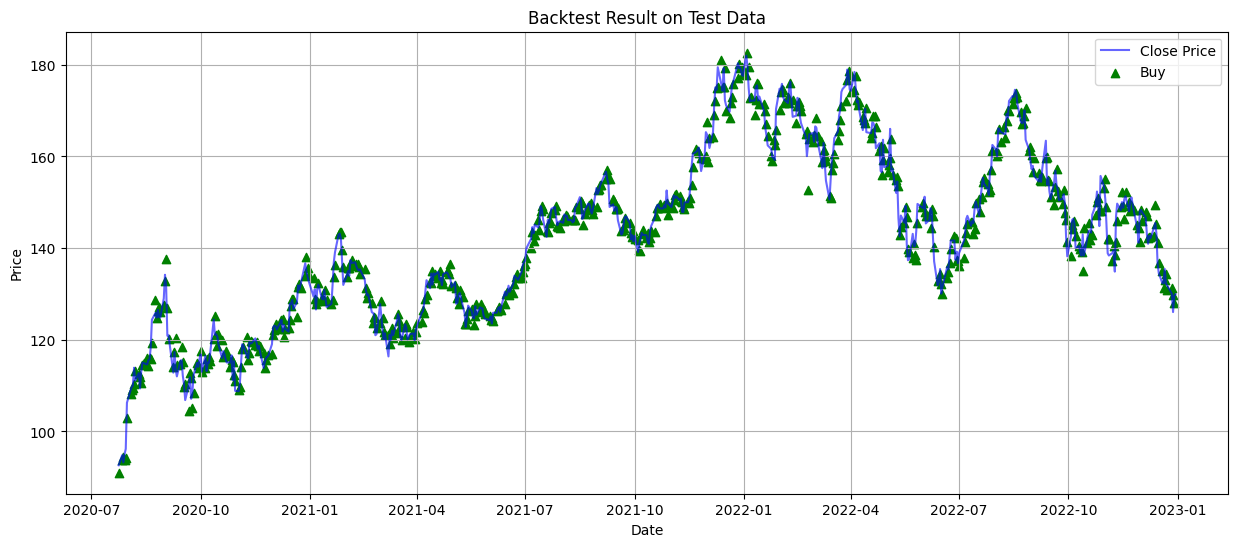

In [ ]:
import matplotlib.pyplot as plt

# Plotting the stock price
plt.figure(figsize=(15,6))
plt.plot(val_data.index, val_data['Close'], label='Close Price', color='blue', alpha=0.6)

# Plotting the buy trades
plt.scatter(buy_dates, buy_prices, marker='^', color='g', alpha=1.0, label='Buy')

plt.title('Backtest Result on Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
obs = env_val.reset()
done = False
buy_dates = []
buy_prices = []
profits = []
equity = [100000]  # Capital inicial, por ejemplo: 100,000

all_dates = []  # Lista para guardar todas las fechas

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _ = env_val.step(action)

    all_dates.append(val_data.index[env_val.envs[0].current_step])

    if action == 1:
        buy_prices.append(val_data.iloc[env_val.envs[0].current_step]['Open'])

    # Actualizar la equity curve basado en las recompensas
    equity.append(equity[-1] + reward)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


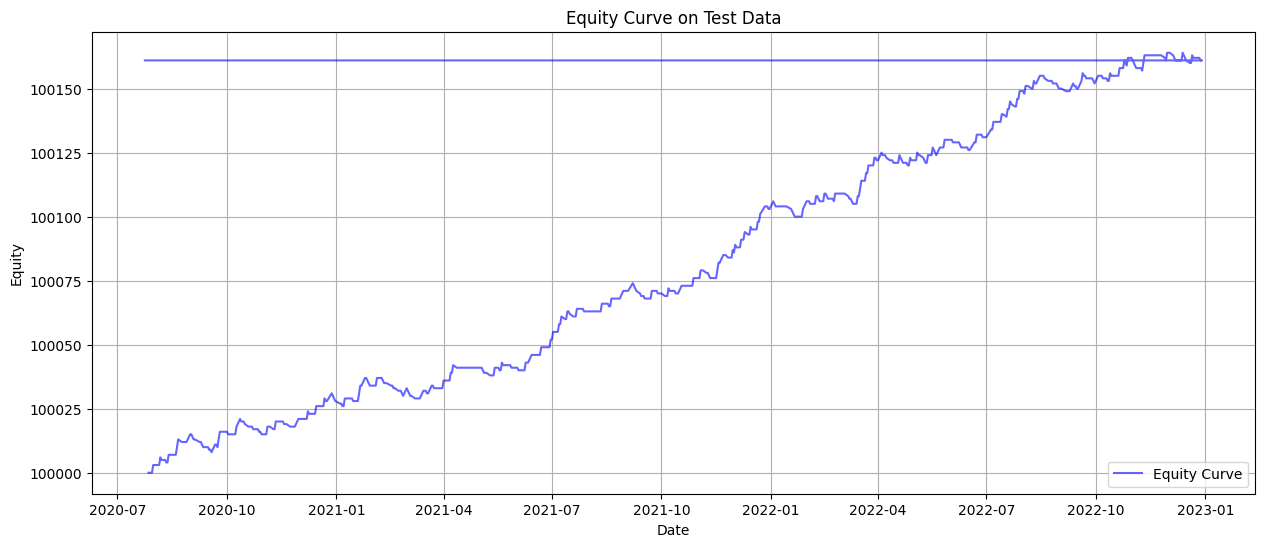

In [ ]:
import matplotlib.pyplot as plt

# Plotting the equity curve
plt.figure(figsize=(15,6))
plt.plot(all_dates, equity[1:], label='Equity Curve', color='blue', alpha=0.6)
plt.title('Equity Curve on Test Data')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
total_return = equity[-1] - equity[0]
print(f"Total return during the test period: ${total_return}")

Total return during the test period: $[161.]


In [ ]:
obs = env_val.reset()
done = False
buy_dates = []
buy_prices = []
profits = []
equity = [100000]  # Capital inicial, por ejemplo: 100,000

all_dates = []  # Lista para guardar todas las fechas

sl_count = 0  # Contador para SLs
tp_count = 0  # Contador para TPs
max_consecutive_sl = 0  # Máximo de SLs consecutivos
max_consecutive_tp = 0  # Máximo de TPs consecutivos
current_consecutive_sl = 0  # Contador temporal para SLs consecutivos
current_consecutive_tp = 0  # Contador temporal para TPs consecutivos

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _ = env_val.step(action)

    all_dates.append(val_data.index[env_val.envs[0].current_step])

    if action == 1:
        buy_prices.append(val_data.iloc[env_val.envs[0].current_step]['Open'])

        # Actualizar la equity curve basado en las recompensas
        equity_delta = 0.01 * equity[-1]  # 1% de la cuenta
        if reward > 0:
            tp_count += 1
            current_consecutive_tp += 1
            current_consecutive_sl = 0  # Reiniciar contador de SLs consecutivos
            equity_delta *= (1 + env_val.envs[0].tp / 100)  # Asumiendo que tp está en porcentaje
        elif reward < 0:
            sl_count += 1
            current_consecutive_sl += 1
            current_consecutive_tp = 0  # Reiniciar contador de TPs consecutivos
            equity_delta *= (1 + env_val.envs[0].sl / 100)  # Asumiendo que sl está en porcentaje

        equity.append(equity[-1] + equity_delta)
    else:
        equity.append(equity[-1])

    max_consecutive_sl = max(max_consecutive_sl, current_consecutive_sl)
    max_consecutive_tp = max(max_consecutive_tp, current_consecutive_tp)

print(f"Total SLs: {sl_count}")
print(f"Total TPs: {tp_count}")
print(f"Max consecutive SLs: {max_consecutive_sl}")
print(f"Max consecutive TPs: {max_consecutive_tp}")

Total SLs: 154
Total TPs: 103
Max consecutive SLs: 7
Max consecutive TPs: 7


## Probar modelo con nuevas fechas

In [ ]:
import yfinance as yf
import datetime

# Obtener la fecha actual
end_date = datetime.datetime.now().strftime('%Y-%m-%d')

# Descargar los datos de Apple desde el 1 de enero de 2023 hasta hoy
data_2023_to_today = yf.download('AAPL', start='2023-01-01', end=end_date, interval="1d")

# Opcionalmente, puedes guardar los datos en un archivo CSV para su uso posterior
data_2023_to_today.to_csv("AAPL_2023_to_today.csv")

# Calcula medias móviles
data_2023_to_today['MA14'] = data_2023_to_today['Close'].rolling(window=14).mean()
data_2023_to_today['MA28'] = data_2023_to_today['Close'].rolling(window=28).mean()
data_2023_to_today['MA100'] = data_2023_to_today['Close'].rolling(window=100).mean()
data_2023_to_today['MA200'] = data_2023_to_today['Close'].rolling(window=200).mean()

# Elimina las filas con NaN (debido a las medias móviles)
data_2023_to_today.dropna(inplace=True)

from stable_baselines3 import PPO

model = PPO.load("path_to_save_model")

from stable_baselines3.common.vec_env import DummyVecEnv

# Crea el entorno con los datos desde 2023 hasta hoy
env_2023_to_today = DummyVecEnv([lambda: TradingEnv(data_2023_to_today)])

# Inicializa el entorno
obs = env_2023_to_today.reset()

# Almacena las predicciones y recompensas
actions = []
rewards = []

for _ in range(len(data_2023_to_today)):
    action, _ = model.predict(obs)
    obs, reward, done, _ = env_2023_to_today.step(action)
    actions.append(action[0])
    rewards.append(reward[0])

print(actions)
print(rewards)


[*********************100%%**********************]  1 of 1 completed
[1, 1, 1, 1, 1, 1, 1, 1, 1]
[0.0, -1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 3.0, 0.0]


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
capital_inicial = 10000  # Capital inicial
capital = capital_inicial
historial_capital = [capital]  # Lista para almacenar la evolución del capital
position_open = False
sl = 1  # Stop loss
tp = 3 * sl  # Take profit es 3 veces el stop loss

for i in range(len(actions)):
    if actions[i] == 1 and not position_open:  # Si la acción es comprar y no hay una posición abierta
        position_open = True
        inversion = 0.01 * capital  # 1% del capital
        capital -= inversion
        entry_price = data_2023_to_today.iloc[i]['Open']

    if position_open:  # Si hay una posición abierta, ajustar el capital según la recompensa
        potential_profit = data_2023_to_today.iloc[i]['Close'] - entry_price
        if potential_profit >= tp:
            capital += inversion * (1 + tp/100)
            position_open = False
        elif potential_profit <= -sl:
            capital += inversion * (1 - sl/100)
            position_open = False

    historial_capital.append(capital)

print(f"Capital final: ${capital:.2f}")
print(f"Rendimiento: {((capital-capital_inicial)/capital_inicial)*100:.2f}%")


Capital final: $10001.00
Rendimiento: 0.01%


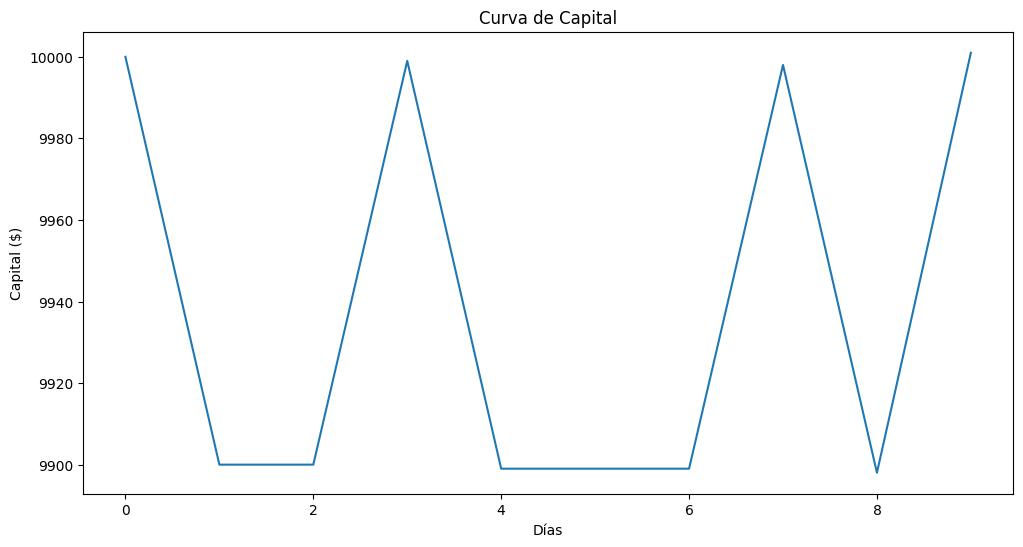

Total TP: 1
Total SL: 2
Máximo TP consecutivo: 1
Máximo SL consecutivo: 2


In [ ]:
# Visualizar la curva de capital
plt.figure(figsize=(12, 6))
plt.plot(historial_capital)
plt.title('Curva de Capital')
plt.xlabel('Días')
plt.ylabel('Capital ($)')
plt.show()

# Contar TP, SL y máximos consecutivos
total_tp = 0
total_sl = 0
consecutive_tp = 0
max_consecutive_tp = 0
consecutive_sl = 0
max_consecutive_sl = 0

for r in rewards:
    if r == tp:
        total_tp += 1
        consecutive_tp += 1
        consecutive_sl = 0
        max_consecutive_tp = max(max_consecutive_tp, consecutive_tp)
    elif r == -sl:
        total_sl += 1
        consecutive_sl += 1
        consecutive_tp = 0
        max_consecutive_sl = max(max_consecutive_sl, consecutive_sl)

print(f"Total TP: {total_tp}")
print(f"Total SL: {total_sl}")
print(f"Máximo TP consecutivo: {max_consecutive_tp}")
print(f"Máximo SL consecutivo: {max_consecutive_sl}")



# FIN APPLE 1:3 ---------------

# Comienzo APPLE 1:7

In [ ]:
# 1. Obtencion de datos
import yfinance as yf

# Descarga los datos de Apple
data = yf.download('AAPL', start='2010-01-01', end='2023-10-01')

# 2. Preparación de datos
# Calcula medias móviles
data['MA14'] = data['Close'].rolling(window=14).mean()
data['MA28'] = data['Close'].rolling(window=28).mean()
data['MA100'] = data['Close'].rolling(window=100).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()

# Elimina las filas con NaN (debido a las medias móviles)
data.dropna(inplace=True)

# Divide los datos en entrenamiento y validación
train_data = data.iloc[:int(0.8*len(data))]
val_data = data.iloc[int(0.8*len(data)):]

#3. Entorno de DRL

import gym
from gym import spaces
import numpy as np


class TradingEnv(gym.Env):
    def __init__(self, data, sl=1, tp=7):
        super(TradingEnv, self).__init__()

        # Datos históricos
        self.data = data
        self.current_step = 0
        self.sl = sl
        self.tp = tp

        # Acciones: 0 = mantener, 1 = comprar
        self.action_space = spaces.Discrete(2)

        # Estado: OHLC + Volumen + 4 medias móviles
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(9,), dtype=np.float32)

        # Comprobar si hay una posición abierta
        self.position_open = False

    def reset(self):
        self.current_step = 0
        self.position_open = False
        return self.data.iloc[self.current_step][['Open', 'High', 'Low', 'Close', 'Volume', 'MA14', 'MA28', 'MA100', 'MA200']].values

    def step(self, action):
        self.current_step += 1

        # Si la acción es comprar y no hay una posición abierta
        if action == 1 and not self.position_open:
            self.position_open = True
            self.entry_price = self.data.iloc[self.current_step]['Open']

        reward = 0
        if self.position_open:
            potential_profit = self.data.iloc[self.current_step]['Close'] - self.entry_price
            if potential_profit >= self.tp:
                reward = self.tp
                self.position_open = False  # Cerrar posición
            elif potential_profit <= -self.sl:
                reward = -self.sl
                self.position_open = False  # Cerrar posición

        done = False
        if self.current_step == len(self.data) - 1:
            done = True

        return self.data.iloc[self.current_step][['Open', 'High', 'Low', 'Close', 'Volume', 'MA14', 'MA28', 'MA100', 'MA200']].values, reward, done, {}


    def render(self, mode='human'):
        # Aquí puedes agregar código para visualizar el proceso, si lo deseas
        pass

    def close(self):
        pass

# 4. Entrenamiento del modelo

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Crea el entorno con los datos de entrenamiento
env_train = DummyVecEnv([lambda: TradingEnv(train_data)])

# Crea el modelo
model_2 = PPO("MlpPolicy", env_train, verbose=1)

# Entrena el modelo
model_2.learn(total_timesteps=300000)

# Evaluar el modelo en datos de validación
env_val = DummyVecEnv([lambda: TradingEnv(val_data)])
obs = env_val.reset()
for _ in range(len(val_data)):
    action, _ = model.predict(obs)
    obs, reward, done, _ = env_val.step(action)

# 5. Guardar el modelo
model_2.save("path_to_save_model_2")


[*********************100%%**********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes
/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cuda device
-----------------------------
| time/              |      |
|    fps             | 265  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 298          |
|    iterations           | 2            |
|    time_elapsed         | 13           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0065245703 |
|    clip_fraction        | 0.0646       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.679       |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 0.363        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00296     |
|    value_loss           | 1.89         |
-----------------------------------------

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


NameError: ignored

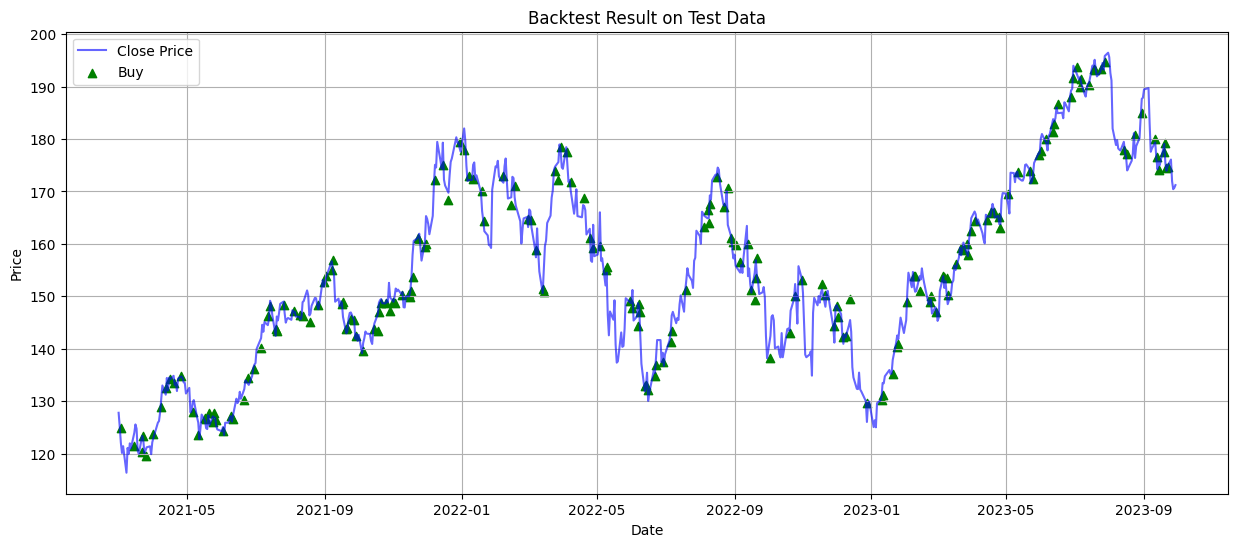

In [ ]:
obs = env_val.reset()
done = False
buy_dates = []
buy_prices = []

while not done:
    action, _ = model_2.predict(obs)
    obs, _, done, _ = env_val.step(action)
    if action == 1:
        buy_dates.append(val_data.index[env_val.envs[0].current_step])
        buy_prices.append(val_data.iloc[env_val.envs[0].current_step]['Open'])

import matplotlib.pyplot as plt

# Plotting the stock price
plt.figure(figsize=(15,6))
plt.plot(val_data.index, val_data['Close'], label='Close Price', color='blue', alpha=0.6)

# Plotting the buy trades
plt.scatter(buy_dates, buy_prices, marker='^', color='g', alpha=1.0, label='Buy')

plt.title('Backtest Result on Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

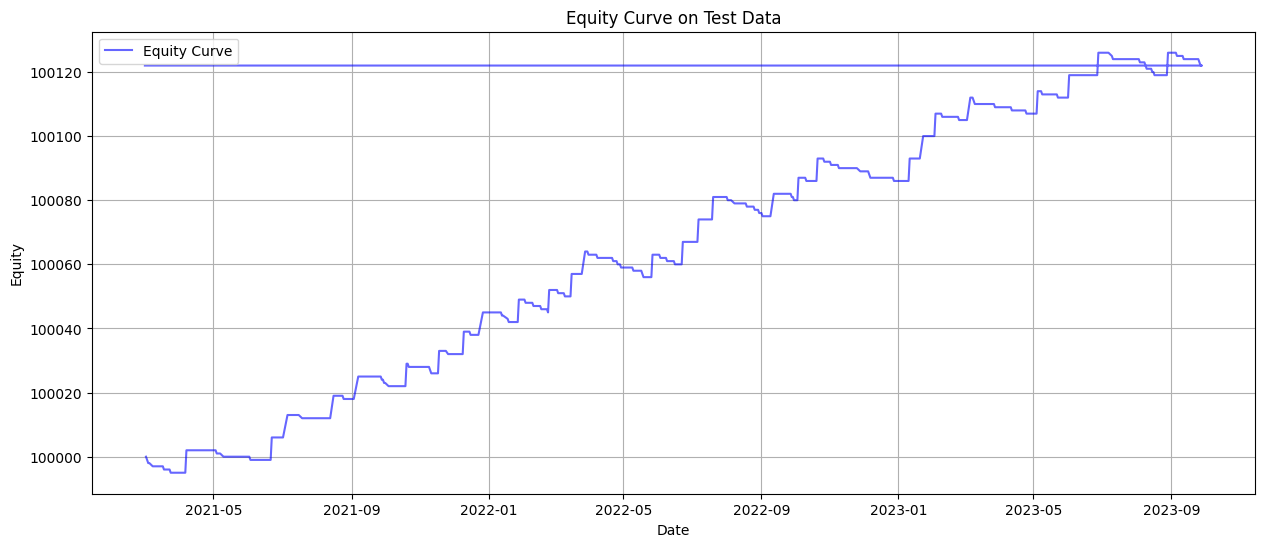

Total TP: 0
Total SL: 0
Máximo TP consecutivo: 0
Máximo SL consecutivo: 0


In [ ]:
obs = env_val.reset()
done = False
buy_dates = []
buy_prices = []
profits = []
equity = [100000]  # Capital inicial, por ejemplo: 100,000

all_dates = []  # Lista para guardar todas las fechas

while not done:
    action, _ = model_2.predict(obs)
    obs, reward, done, _ = env_val.step(action)

    all_dates.append(val_data.index[env_val.envs[0].current_step])

    if action == 1:
        buy_prices.append(val_data.iloc[env_val.envs[0].current_step]['Open'])

    # Actualizar la equity curve basado en las recompensas
    equity.append(equity[-1] + reward)

import matplotlib.pyplot as plt

# Plotting the equity curve
plt.figure(figsize=(15,6))
plt.plot(all_dates, equity[1:], label='Equity Curve', color='blue', alpha=0.6)
plt.title('Equity Curve on Test Data')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
total_tp = 0
total_sl = 0
consecutive_tp = 0
max_consecutive_tp = 0
consecutive_sl = 0
max_consecutive_sl = 0

obs = env_val.reset()
for _ in range(len(val_data)):
    action, _ = model_2.predict(obs)
    obs, reward, done, _ = env_val.step(action)

    # Determinar si se alcanza TP o SL basado en la recompensa
    if reward == env_val.envs[0].tp:
        total_tp += 1
        consecutive_tp += 1
        consecutive_sl = 0
        max_consecutive_tp = max(max_consecutive_tp, consecutive_tp)
    elif reward == -env_val.envs[0].sl:
        total_sl += 1
        consecutive_sl += 1
        consecutive_tp = 0
        max_consecutive_sl = max(max_consecutive_sl, consecutive_sl)

print(f"Total TP: {total_tp}")
print(f"Total SL: {total_sl}")
print(f"Máximo TP consecutivo: {max_consecutive_tp}")
print(f"Máximo SL consecutivo: {max_consecutive_sl}")


Total TP: 28
Total SL: 59
Máximo TP consecutivo: 3
Máximo SL consecutivo: 10


### visualizar cada operación con plotly

In [ ]:
# Cargar el modelo
loaded_model = PPO.load("path_to_save_model")

# Voy a hacerlo con EURUSD (100 pips SL y 300 pips TP)

In [ ]:
# 1. Obtencion de datos
import yfinance as yf

# Descarga los datos de EUR/USD con intervalo de 1 hora
data = yf.download('EURUSD=X', start='2021-11-01', end='2023-10-01', interval='1h')

# 2. Preparación de datos
data['MA14'] = data['Close'].rolling(window=14).mean()
data['MA28'] = data['Close'].rolling(window=28).mean()
data['MA100'] = data['Close'].rolling(window=100).mean()
data['MA200'] = data['Close'].rolling(window=200).mean()
data.dropna(inplace=True)
train_data = data.iloc[:int(0.8*len(data))]
val_data = data.iloc[int(0.8*len(data)):]

#3. Entorno de DRL
import gym
from gym import spaces
import numpy as np
import os

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import load_results
from stable_baselines3.common.results_plotter import ts2xy
from stable_baselines3.common.monitor import Monitor

model_save_path = os.path.join("path_to_save_model_3", "model")
monitor_save_path = os.path.join("path_to_save_model_3", "monitor")

# Envuelve el entorno con el Monitor antes de usarlo en DummyVecEnv
train_env = TradingEnv(train_data)
monitored_train_env = Monitor(train_env, filename=os.path.join(monitor_save_path, "monitor.csv"))
env_train = DummyVecEnv([lambda: monitored_train_env])

class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).
    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, save_path: str, monitor_path: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        self.monitor_path = monitor_path
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs("path_to_save_model_3", exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.monitor_path), 'timesteps')
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                  print(f"Num timesteps: {self.num_timesteps}")
                  print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                      print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True


class TradingEnv(gym.Env):
    def __init__(self, data, sl=0.0020, tp=0.0080):  # 100 pips SL y 300 pips TP
        super(TradingEnv, self).__init__()
        self.data = data
        self.current_step = 0
        self.sl = sl
        self.tp = tp
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(9,), dtype=np.float32)
        self.position_open = False

    def reset(self):
        self.current_step = 0
        self.position_open = False
        return self.data.iloc[self.current_step][['Open', 'High', 'Low', 'Close', 'Volume', 'MA14', 'MA28', 'MA100', 'MA200']].values

    def step(self, action):
        self.current_step += 1

        # Si la acción es comprar y no hay una posición abierta
        if action == 1 and not self.position_open:
            self.position_open = True
            self.entry_price = self.data.iloc[self.current_step]['Open']

        reward = 0
        if self.position_open:
            potential_profit = self.data.iloc[self.current_step]['Close'] - self.entry_price
            if potential_profit >= self.tp:
                reward = self.tp
                self.position_open = False  # Cerrar posición
            elif potential_profit <= -self.sl:
                reward = -self.sl
                self.position_open = False  # Cerrar posición

        done = False
        if self.current_step >= len(self.data) - 1:
          done = True

        return self.data.iloc[self.current_step][['Open', 'High', 'Low', 'Close', 'Volume', 'MA14', 'MA28', 'MA100', 'MA200']].values, reward, done, {}

    def render(self, mode='human'):
        # Aquí puedes agregar código para visualizar el proceso, si lo deseas
        pass

    def close(self):
        pass

# 4. Entrenamiento del modelo
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

env_train = DummyVecEnv([lambda: TradingEnv(train_data)])
model_3 = PPO("MlpPolicy", env_train, verbose=1)
# Define the callback
save_callback = SaveOnBestTrainingRewardCallback(check_freq=10000, save_path=model_save_path, monitor_path=monitor_save_path)

# Train the model
model_3.learn(total_timesteps=100000, callback=save_callback)

# Download the model
from google.colab import files
files.download('path_to_save_model_3.zip')

# Evaluar el modelo en datos de validación
env_val = DummyVecEnv([lambda: TradingEnv(val_data)])
obs = env_val.reset()
for _ in range(len(val_data)):
    action, _ = model_3.predict(obs)
    obs, reward, done, _ = env_val.step(action)

# 5. Guardar el modelo
model_3.save("path_to_save_model_3")


[*********************100%%**********************]  1 of 1 completed


ModuleNotFoundError: ignored

In [ ]:
model_3 = model.load("/content/path_to_save_model_3.zip")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Supongamos que ya has guardado el modelo anteriormente con el nombre "path_to_save_model_3.zip" en el directorio "path_to_save_model_3"
from stable_baselines3 import PPO

# Carga el modelo
model_3 = PPO.load("path_to_save_model_3.zip")

train_env = TradingEnv(train_data)
monitored_train_env = Monitor(train_env, filename=os.path.join(monitor_save_path, "monitor.csv"))
env_train = DummyVecEnv([lambda: monitored_train_env])

model_3.observation_space = env_train.observation_space
model_3.set_env(env_train)

# Continúa el entrenamiento
model_3.learn(total_timesteps=30000, callback=save_callback)

ValueError: ignored

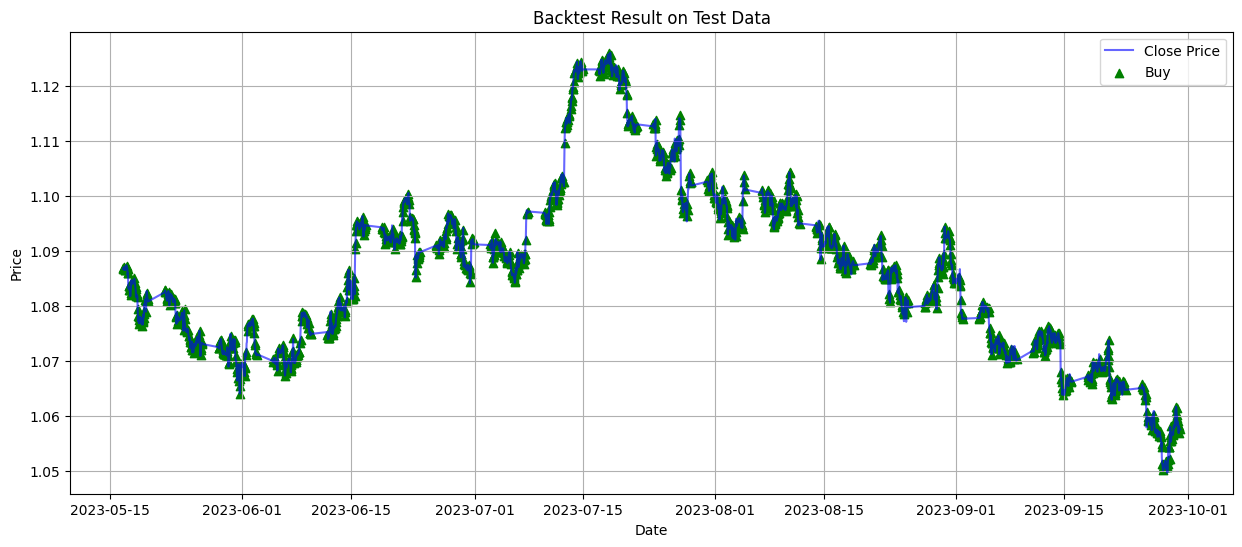

In [ ]:
obs = env_val.reset()
done = False
buy_dates = []
buy_prices = []

while not done:
    action, _ = model_3.predict(obs)
    obs, _, done, _ = env_val.step(action)
    if action == 1:
        buy_dates.append(val_data.index[env_val.envs[0].current_step])
        buy_prices.append(val_data.iloc[env_val.envs[0].current_step]['Open'])

import matplotlib.pyplot as plt

# Plotting the stock price
plt.figure(figsize=(15,6))
plt.plot(val_data.index, val_data['Close'], label='Close Price', color='blue', alpha=0.6)

# Plotting the buy trades
plt.scatter(buy_dates, buy_prices, marker='^', color='g', alpha=1.0, label='Buy')

plt.title('Backtest Result on Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

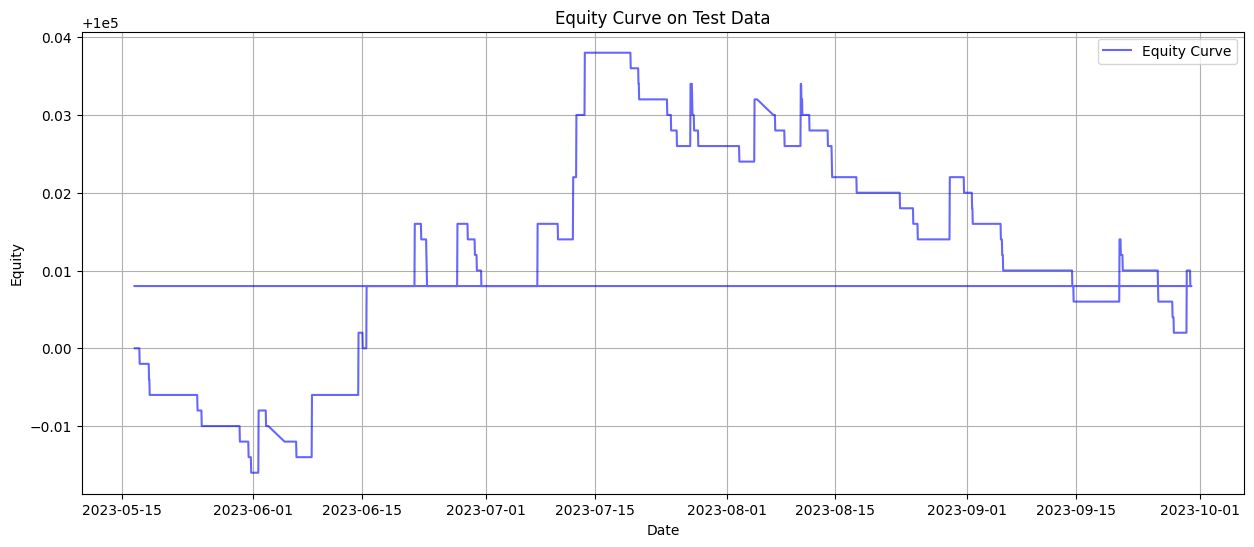

In [ ]:
obs = env_val.reset()
done = False
buy_dates = []
buy_prices = []
profits = []
equity = [100000]  # Capital inicial, por ejemplo: 100,000

all_dates = []  # Lista para guardar todas las fechas

while not done:
    action, _ = model_3.predict(obs)
    obs, reward, done, _ = env_val.step(action)

    all_dates.append(val_data.index[env_val.envs[0].current_step])

    if action == 1:
        buy_prices.append(val_data.iloc[env_val.envs[0].current_step]['Open'])

    # Actualizar la equity curve basado en las recompensas
    equity.append(equity[-1] + reward)

import matplotlib.pyplot as plt

# Plotting the equity curve
plt.figure(figsize=(15,6))
plt.plot(all_dates, equity[1:], label='Equity Curve', color='blue', alpha=0.6)
plt.title('Equity Curve on Test Data')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
obs = env_val.reset()
done = False
buy_dates = []
buy_prices = []
profits = []
equity = [100000]  # Capital inicial, por ejemplo: 100,000

all_dates = []  # Lista para guardar todas las fechas

sl_count = 0  # Contador para SLs
tp_count = 0  # Contador para TPs
max_consecutive_sl = 0  # Máximo de SLs consecutivos
max_consecutive_tp = 0  # Máximo de TPs consecutivos
current_consecutive_sl = 0  # Contador temporal para SLs consecutivos
current_consecutive_tp = 0  # Contador temporal para TPs consecutivos

while not done:
    action, _ = model_3.predict(obs)
    obs, reward, done, _ = env_val.step(action)

    all_dates.append(val_data.index[env_val.envs[0].current_step])

    if action == 1:
        buy_prices.append(val_data.iloc[env_val.envs[0].current_step]['Open'])

        # Actualizar la equity curve basado en las recompensas
        equity_delta = 0.01 * equity[-1]  # 1% de la cuenta
        if reward > 0:
            tp_count += 1
            current_consecutive_tp += 1
            current_consecutive_sl = 0  # Reiniciar contador de SLs consecutivos
            equity_delta *= (1 + env_val.envs[0].tp / 100)  # Asumiendo que tp está en porcentaje
        elif reward < 0:
            sl_count += 1
            current_consecutive_sl += 1
            current_consecutive_tp = 0  # Reiniciar contador de TPs consecutivos
            equity_delta *= (1 + env_val.envs[0].sl / 100)  # Asumiendo que sl está en porcentaje

        equity.append(equity[-1] + equity_delta)
    else:
        equity.append(equity[-1])

    max_consecutive_sl = max(max_consecutive_sl, current_consecutive_sl)
    max_consecutive_tp = max(max_consecutive_tp, current_consecutive_tp)

print(f"Total SLs: {sl_count}")
print(f"Total TPs: {tp_count}")
print(f"Max consecutive SLs: {max_consecutive_sl}")
print(f"Max consecutive TPs: {max_consecutive_tp}")

Total SLs: 21
Total TPs: 5
Max consecutive SLs: 11
Max consecutive TPs: 3
